In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnew-csv/vietnew_dataset/val_tokenized
/kaggle/input/vietnew-csv/vietnew_dataset/train_tokenized
/kaggle/input/vietnew-csv/vietnew_dataset/test_tokenized


In [2]:
#!pip install https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz

In [3]:
!pip install spacy==2.1.4
!pip install pyvi
!pip3 install https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz --user
!python3 -m spacy link vi_spacy_model vi_spacy_model
!python3 -m spacy info

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.3
    Uninstalling srsly-2.4.3:
      Successfully uninstalled srsly-2.4.3
  Attempting uninstall: preshed
    Found existing installation: preshed 3.0.6
    Uninstalling preshed-3.0.6:
      Successfully uninstalled preshed-3.0.6
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.4.0
    Uninstalling jsonschema-4.4.0:
      Successfully uninstalled jsonschema-4.4.0
  Attempting uninstall: blis
    Found existing 

In [4]:
train = pd.read_csv('/kaggle/input/vietnew-csv/vietnew_dataset/train_tokenized')
val = pd.read_csv('/kaggle/input/vietnew-csv/vietnew_dataset/val_tokenized')
test = pd.read_csv('/kaggle/input/vietnew-csv/vietnew_dataset/test_tokenized')

In [5]:
def resize_df(data):
    data['Number_of_words'] = data.source_text.apply(lambda x: len(x.split()))
    data['Number_of_words_target'] = data.target_text.apply(lambda x: len(x.split()))
    data = data.loc[(data['Number_of_words'] < 512) & 
                    (data['Number_of_words'] > 200) &
                    (data['Number_of_words_target'] < 38) &
                    (data['Number_of_words_target'] > 15)]
    return data

In [6]:
train_df = resize_df(train)
test_df = resize_df(test)
val_df = resize_df(val)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56460 entries, 0 to 105417
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              56460 non-null  int64 
 1   source_text             56460 non-null  object
 2   target_text             56460 non-null  object
 3   Number_of_words         56460 non-null  int64 
 4   Number_of_words_target  56460 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


In [8]:
import re
def text_strip(column):
    for row in column:
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        row=re.sub("(video)", ' ', str(row)).lower() #remove video
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!           
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        yield row

In [9]:
brief_cleaning1 = text_strip(train_df['source_text'])
brief_cleaning2 = text_strip(train_df['target_text'])

In [10]:
from time import time
import spacy
nlp = spacy.load('vi_spacy_model')
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 28.78 mins


In [11]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.59 mins


In [12]:
text[0]

'dân_thường damascus syria chạy loạn bình_nhưỡng cho_rằng bản phúc_trình mới_đây của liên_hợp_quốc cáo_buộc triều_tiên hỗ_trợ syria sản_xuất vũ_khí_hoá_học là thêu_dệt nhằm gây sức_ép reuters dẫn lời hãng thông_tấn trung_ương triều_tiên kcna đưa tin như chúng_tôi đã nói rõ nhiều lần chúng_tôi không phát_triển sản_xuất hay lưu_trữ vũ_khí_hoá_học và chúng_tôi phản_đối vũ_khí_hoá_học người_phát_ngôn viện nghiên_cứu về mỹ trực_thuộc bộ ngoại_giao triều_tiên nhấn_mạnh theo liên_hợp_quốc triều_tiên đã vận_chuyển các vật_dụng như nhiệt_kế và van trong ít_nhất 40 chuyến hàng_không khai_báo từ triều_tiên đến syria trong khoảng thời_gian từ năm 2012 đến 2017 báo_cáo được tiết_lộ cho một_số hãng tin trong bối_cảnh mỹ và các nước khác cáo_buộc chính_phủ syria sử_dụng vũ_khí_hoá_học tấn_công thường_dân gần đây nhất_là tại ghouta khu ngoại_ô phía đông damascus báo_cáo do một nhóm chuyên_gia giám_sát thực_thi lệnh chế_tài của liên_hợp_quốc đối_với bình_nhưỡng thực_hiện nói rằng các chuyên_viên tên_lử

In [13]:
summary[0]

'_START_ triều_tiên bác_bỏ cáo_buộc nước này bán các loại chất_liệu cho chế_độ của tổng_thống syria_bashar_assad dùng để chế_tạo vũ_khí_hoá_học  _END_'

In [14]:
train_df['cleaned_text'] = pd.Series(text)
train_df['cleaned_summary'] = pd.Series(summary)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
print("Number of data nan:",sum(train_df.isnull().values.ravel()))
print('Number of duplicate:',sum(train_df.duplicated()))
train_df =train_df.dropna()
print("Shape of data after drop nan:",train_df.shape)
train_df.head(5)

Number of data nan: 52560
Number of duplicate: 0
Shape of data after drop nan: (30180, 7)


,Unnamed: 0,source_text,target_text,Number_of_words,Number_of_words_target,cleaned_text,cleaned_summary
0,0,"Dân_thường ở Damascus , Syria chạy loạn . Bình...",Triều_Tiên bác bỏ cáo_buộc nước này bán các lo...,213,20,dân_thường damascus syria chạy loạn bình_nhưỡn...,_START_ triều_tiên bác_bỏ cáo_buộc nước này bá...
1,1,"Theo đó , khoảng 10h ngày 30/6 , ngọn lửa bắt_...","Đám cháy bùng_phát ở khu_vực rừng thông , do t...",256,27,theo đó khoảng 10h ngày 30/6 ngọn lửa bắt_đầu ...,_START_ đám cháy bùng_phát khu_vực rừng thông ...
3,3,Món đồ_chơi tình_dục bị nghi là bom . Chuyến b...,Chuyến bay của hãng AirAsia khởi_hành từ sân_b...,234,27,tổng_thống mỹ donald_trump và cựu_bộ_trưởng tư...,_START_ các nghị_sĩ đảng dân_chủ muốn quốc_hội...
5,5,Tổng_thống Mỹ Donald_Trump và cựu Bộ_trưởng Tư...,Các nghị_sĩ đảng Dân_chủ muốn Quốc_hội Mỹ thôn...,317,21,bức_ảnh trên truyền_hình đang gây xôn_xao tron...,_START_ truyền_hình triều_tiên dường_như chiếu...
6,6,"Ngày 29-11 , TAND quận Ninh_Kiều đưa ra xét_xử...",Với cáo_buộc nhiều lần làm lộ thông_tin nội_bộ...,505,33,nsưt công_lý cho biết anh vừa cùng xuân_bắc vâ...,_START_ sáng 11/4 nsưt công_lý xuân_bắc và vân...


In [16]:
max_text_len=512
max_summary_len=38

In [17]:
short_text=[]
short_summary=[]

cleaned_text =np.array(train_df['cleaned_text'])
cleaned_summary=np.array(train_df['cleaned_summary'])

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [18]:
post_pre.head(2)

,text,summary
0,dân_thường damascus syria chạy loạn bình_nhưỡn...,_START_ triều_tiên bác_bỏ cáo_buộc nước này bá...
1,theo đó khoảng 10h ngày 30/6 ngọn lửa bắt_đầu ...,_START_ đám cháy bùng_phát khu_vực rừng thông ...


In [19]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [21]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [22]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.5434312878133
Total Coverage of rare words: 0.8844746836493173


In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 18010


In [24]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 70.81106204973274
Total Coverage of rare words: 1.5101321494834439


In [26]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 3769


In [27]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [28]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [29]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 18010


2022-05-16 18:21:47.828343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 18:21:47.829727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 18:21:47.830429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 18:21:47.831551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 512, 200)     3602000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 512, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [32]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

2022-05-16 18:21:53.533277: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
213/213 [==============================] - 1419s 7s/step - loss: 5.6870 - val_loss: 5.3338
Epoch 2/20
213/213 [==============================] - 1414s 7s/step - loss: 5.1197 - val_loss: 4.7933
Epoch 3/20
213/213 [==============================] - 1415s 7s/step - loss: 4.6259 - val_loss: 4.4162
Epoch 4/20
213/213 [==============================] - 1426s 7s/step - loss: 4.3139 - val_loss: 4.1782
Epoch 5/20
213/213 [==============================] - 1431s 7s/step - loss: 4.1098 - val_loss: 4.0053
Epoch 6/20
213/213 [==============================] - 1443s 7s/step - loss: 3.9539 - val_loss: 3.8874
Epoch 7/20
213/213 [==============================] - 1449s 7s/step - loss: 3.8311 - val_loss: 3.7906
Epoch 8/20
213/213 [==============================] - 1434s 7s/step - loss: 3.7365 - val_loss: 3.7316
Epoch 9/20
213/213 [==============================] - 1448s 7s/step - loss: 3.6591 - val_loss: 3.6697
Epoch 10/20
213/213 [==============================] - 1455s 7s/step - loss: 3.593

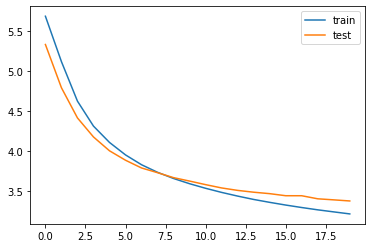

In [33]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [35]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [38]:
for i in range(0,5):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: tổng thống mỹ donald trump tôi hy vọng ông trump bị ám sát maria thượng nghị sĩ đảng dân chủ của bang missouri hôm 17 8 đăng một bình luận trên facebook theo báo st louis post dispatch dù bà sau đó xoá thông điệp và xin lỗi về ngôn từ nó vẫn bị xem xét văn phòng mật vụ st louis field đang xem xét các bình luận cnn dẫn lời cathy phát ngôn viên mật vụ cho biết mật vụ điều tra tất cả những lời đe doạ tổng thống phó tổng thống và những người được bảo vệ khác dù đó là lời trực diện ám chỉ hay bình luận thoáng qua cho biết bà đăng bình luận do thất vọng với môi trường chính trị hiện nay không tôi không muốn thấy ai bị ám sát nhưng ông ấy không nên làm tổng thống ông ấy cần bị luận tội bà nói với ai đó đăng lên facebook của tôi và tôi đáp lại bằng điều đáng lẽ không nên đăng lên đó các nhà lập pháp bang nhanh chóng phản ứng trước phát ngôn và kêu gọi bà từ chức claire thượng nghị sĩ bang missouri theo đảng dân chủ tuyên bố tôi lên án điều đó điều đó là sự xúc phạm và bà nên từ chức er